# Sparse Network: MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.metrics.cluster.supervised import fowlkes_mallows_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")    #category=DeprecationWarning, message='is a deprecated alias'

useSparseNetwork = True
if(useSparseNetwork):
    paralleliseSparseProcessing = True   #parallel processing of sparse filters using Conv1d/Conv2d groups parameter
    if(paralleliseSparseProcessing):
        paralleliseSparseProcessingPrintTime = False
        if(paralleliseSparseProcessingPrintTime):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
    
    numberOfEpochsMLP = 1   #default: 10
    numberOfEpochsCNN = 1   #default: 10
    numberOfSparseLayersCNN = 2 #default: 1 (1 or 2)
    numberOfSparseLayersMLP = 2 #default: 1 (1 or 2)
else:
    numberOfEpochsMLP = 1   #default: 20
    numberOfEpochsCNN = 1   #default: 10
    numberOfSparseLayersCNN = 1 #default: 1 #additional dense hidden layers
    numberOfSparseLayersMLP = 1 #default: 0 #additional dense hidden layers

#set Runtime type = high RAM
#numberOfchannelsFirstDenseLayer: max value determined by numberOfSparseLayers, GPU RAM (independent of batchSize)

#first/dense MLP layer;
if(numberOfSparseLayersMLP == 0):
    numberOfchannelsFirstDenseLayerMLP = 100	#hidden_dim
    batchSizeMLP = 1024 #128
elif(numberOfSparseLayersMLP == 1):
    numberOfchannelsFirstDenseLayerMLP = 100
    batchSizeMLP = 1024 #128
elif(numberOfSparseLayersMLP == 2):
    numberOfchannelsFirstDenseLayerMLP = 20 #2
    batchSizeMLP = 1024 #128
else:
    print("useSparseNetwork warning: numberOfSparseLayersMLP is too high for compute/memory")
    numberOfchannelsFirstDenseLayerMLP = 2
    batchSizeMLP = 16
    
#first/dense CNN layer;
if(numberOfSparseLayersCNN == 0):
    numberOfchannelsFirstDenseLayerCNN = 32
    batchSizeCNN = 4096    #1024
elif(numberOfSparseLayersCNN == 1):
    numberOfchannelsFirstDenseLayerCNN = 32
    batchSizeCNN = 4096    #1024
elif(numberOfSparseLayersCNN == 2):
    numberOfchannelsFirstDenseLayerCNN = 8
    batchSizeCNN = 4096    #1024
else:
    print("useSparseNetwork warning: numberOfSparseLayersCNN is too high for compute/memory")
    numberOfchannelsFirstDenseLayerCNN = 2
    batchSizeCNN = 16

learningAlgorithmLUANN = False
onlyTrainFinalLayer = False #initialise dependent var
if(learningAlgorithmLUANN):
    onlyTrainFinalLayer = True

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


## Sparse Layer Processing


In [3]:
class SparseLayerProcessing():
    def __init__(self, isCNNmodel, numberOfSparseLayers, layerDropout, numberOfchannelsFirstDenseLayer, kernelSize=None, padding=None, stride=None, maxPoolSize=None):

        self.isCNNmodel = isCNNmodel

        self.numberOfSparseLayers = numberOfSparseLayers
        self.layerDropout = layerDropout
        self.numberOfchannelsFirstDenseLayer = numberOfchannelsFirstDenseLayer
        self.sparseLayerList = [None]*self.numberOfSparseLayers

        if(isCNNmodel):
            self.kernelSize = kernelSize
            self.padding = padding
            self.stride = stride
            self.maxPoolSize = maxPoolSize

    def generateSparseLayers(self, numberOfchannels, height=None, width=None):
        for layerIndex in range(self.numberOfSparseLayers):
            #print("layerIndex = ", layerIndex)
            if(useSparseNetwork):
                layer, numberOfchannels = self.generateSparseLayer(numberOfchannels)
                self.sparseLayerList[layerIndex] = layer
                if(self.isCNNmodel):
                    height, width = self.getImageDimensionsAfterConv(height, width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
            else:
                #only used by CNN originally:
                numberOfInputChannels = numberOfchannels
                numberOfOutputChannels = numberOfchannels*2
                layer = self.generateLayerStandard(numberOfchannels, numberOfOutputChannels)
                self.sparseLayerList[layerIndex] = layer
                numberOfchannels = numberOfOutputChannels
                if(self.isCNNmodel):
                    height, width = self.getImageDimensionsAfterConv(height, width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
                
        return numberOfchannels, height, width

    def generateSparseLayer(self, numberOfchannels):
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        #print("numberOfchannels = ", numberOfchannels)
        #print("numChannelPairs = ", numChannelPairs)
        numberOfInputChannels = 2
        numberOfOutputChannels = 1
        if(paralleliseSparseProcessing):
            layer = self.generateSparseLayerParallel(numChannelPairs, numberOfInputChannels, numberOfOutputChannels)
        else:
            layer = self.generateSparseLayerStandard(numChannelPairs, numberOfInputChannels, numberOfOutputChannels)
        numberOfchannels = numChannelPairs*numberOfOutputChannels
        return layer, numberOfchannels
    def generateSparseLayerStandard(self, numChannelPairs, numberOfInputChannels, numberOfOutputChannels):
        sparseSublayerList = []
        for channelPairIndex in range(numChannelPairs):
            sublayer = self.generateLayerStandard(numberOfInputChannels, numberOfOutputChannels)
            sparseSublayerList.append(sublayer)
        return sparseSublayerList
    def generateSparseLayerParallel(self, numChannelPairs, numberOfInputChannels, numberOfOutputChannels):
        layer = self.generateLayerParallel(numChannelPairs, numberOfInputChannels, numberOfOutputChannels)
        return layer

    def generateLayerParallel(self, numChannelPairs, numberOfInputChannels, numberOfOutputChannels):
        if(self.isCNNmodel):
            return self.generateLayerParallelCNN(numChannelPairs, numberOfInputChannels, numberOfOutputChannels)
        else:
            return self.generateLayerParallelMLP(numChannelPairs, numberOfInputChannels, numberOfOutputChannels)
    def generateLayerParallelMLP(self, numChannelPairs, numberOfInputChannels, numberOfOutputChannels):
        #https://stackoverflow.com/questions/58374980/run-multiple-models-of-an-ensemble-in-parallel-with-pytorch/58389075#58389075
        layer = nn.Conv1d(numberOfInputChannels*numChannelPairs, numberOfOutputChannels*numChannelPairs, kernel_size=1, groups=numChannelPairs)
        return layer
    def generateLayerParallelCNN(self, numChannelPairs, numberOfInputChannels, numberOfOutputChannels):
        conv2DnumberSubChannels = numberOfInputChannels*numChannelPairs
        layer = nn.Conv2d(conv2DnumberSubChannels, conv2DnumberSubChannels, kernel_size=self.kernelSize, padding=self.padding, stride=self.stride, groups=conv2DnumberSubChannels)
        return layer

    def generateLayerStandard(self, numberOfInputChannels, numberOfOutputChannels):
        if(self.isCNNmodel):
            return self.generateLayerStandardCNN(numberOfInputChannels, numberOfOutputChannels)
        else:
            return self.generateLayerStandardMLP(numberOfInputChannels, numberOfOutputChannels)
    def generateLayerStandardMLP(self, numberOfInputChannels, numberOfOutputChannels):
        layer = nn.Linear(numberOfInputChannels, numberOfOutputChannels)
        return layer
    def generateLayerStandardCNN(self, numberOfInputChannels, numberOfOutputChannels):
        layer = nn.Conv2d(numberOfInputChannels, numberOfOutputChannels, kernel_size=self.kernelSize, padding=self.padding, stride=self.stride)
        return layer

    def executeSparseLayers(self, X):
        numberOfchannels = self.numberOfchannelsFirstDenseLayer
        for layerIndex in range(self.numberOfSparseLayers):
            if(useSparseNetwork):
                layerZ, numberOfchannels = self.executeSparseLayer(layerIndex, X, numberOfchannels)
            else:
                layerIn = X
                layerZ = (self.sparseLayerList[layerIndex])(layerIn)
            layerOut = self.activationFunction(layerZ)
            X = layerOut
        return X
    
    def executeSparseLayer(self, layerIndex, X, numberOfchannels):
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        numberOfInputChannels = 2
        numberOfOutputChannels = 1
        channelsPairsList = self.convertToChannelsToChannelPairsList(X)
        if(paralleliseSparseProcessing):
            layerZ = self.executeSparseLayerParallel(layerIndex, channelsPairsList, numChannelPairs)
        else:
            layerZ = self.executeSparseLayerStandard(layerIndex, channelsPairsList, numChannelPairs)
        numberOfchannels = numChannelPairs*numberOfOutputChannels
        return layerZ, numberOfchannels
    def executeSparseLayerStandard(self, layerIndex, channelsPairsList, numChannelPairs):
        channelPairSublayerOutputList = []
        for channelPairIndex in range(numChannelPairs):
            sublayerIn = channelsPairsList[channelPairIndex]
            sublayerOut = (self.sparseLayerList[layerIndex])[channelPairIndex](sublayerIn)
            sublayerOut = torch.squeeze(sublayerOut, dim=1)   #remove channel dim (size=numberOfOutputChannels=1); prepare for convertChannelPairLINoutputListToChannels execution
            channelPairSublayerOutputList.append(sublayerOut)
        layerZ = self.convertChannelPairSublayerOutputListToChannels(channelPairSublayerOutputList)
        return layerZ
    def executeSparseLayerParallel(self, layerIndex, channelsPairsList, numChannelPairs):
        firstTensorInList = channelsPairsList[0]    #shape = [batchSize, numberOfInputChannels, ..]
        print("executeSparseLayerParallel: layerIndex = ", layerIndex, ", firstTensorInList.shape = ", firstTensorInList.shape, ", numChannelPairs = ", numChannelPairs)
        tensorPropertiesTuple = self.getSublayerTensorProperties(firstTensorInList)   #get properties from first tensor in list
        #numChannelPairs = len(channelsPairsList)
        channelsPairs = torch.stack(channelsPairsList, dim=1)   #shape = [batchSize, numChannelPairs, numberOfInputChannels, ..]
        if(self.isCNNmodel):
            if(paralleliseSparseProcessingPrintTime):
                start.record()
            (batchSize, numberOfInputChannels, height, width) = tensorPropertiesTuple
            conv2DnumberSubChannels = numberOfInputChannels*numChannelPairs
            layerIn = torch.reshape(channelsPairs, (batchSize, numChannelPairs*numberOfInputChannels, height, width))
            layerZ = (self.sparseLayerList[layerIndex])(layerIn)  #channels convoluted separately (in separate groups)
            height, width = self.getImageDimensionsAfterConv(height, width, self.kernelSize, self.padding, self.stride, 1)  #no max pool has been performed
            layerZ = torch.reshape(layerZ, (batchSize, numChannelPairs, numberOfInputChannels, height, width))
            layerZ = torch.sum(layerZ, dim=2)  #take sum of numberOfInputChannels (emulates element-wise sum as performed by CNN with groups=1)
            if(paralleliseSparseProcessingPrintTime):
                end.record()
                torch.cuda.synchronize()
                print(start.elapsed_time(end))
        else:
            (batchSize, numberOfInputChannels) = tensorPropertiesTuple
            #https://stackoverflow.com/questions/58374980/run-multiple-models-of-an-ensemble-in-parallel-with-pytorch/58389075#58389075
            layerIn = torch.reshape(channelsPairs, (batchSize, numChannelPairs*numberOfInputChannels, 1))
            layerZ = (self.sparseLayerList[layerIndex])(layerIn)
            layerZ = torch.reshape(layerZ, (batchSize, numChannelPairs))
        print("executeSparseLayerParallel: layerZ.shape = ", layerZ.shape)
        #layerZ shape = [batchSize, numChannelPairs, ..]
        return layerZ

    def activationFunction(self, Z, useDropOut=True):
        if(self.isCNNmodel):
            return self.activationFunctionCNN(Z, useDropOut)
        else:
            return self.activationFunctionMLP(Z, useDropOut)
    def activationFunctionMLP(self, Z, useDropOut=True):
        A = F.relu(Z)
        if(useDropOut):
            A = self.layerDropout(A)
        return A
    def activationFunctionCNN(self, Z, useDropOut=True):
        if(useDropOut):
            Z = self.layerDropout(Z)
        A = torch.relu(F.max_pool2d(Z, kernel_size=self.maxPoolSize))
        return A

    def calculateNumberChannelPairs(self, numInputChannels):
        numChannelPairs = numInputChannels**2
        return numChannelPairs
        #numOutputChannels = number of filters

    def convertToChannelsToChannelPairsList(self, channels):
        tensorPropertiesTuple = self.getSublayerTensorProperties(channels)
        batchSize = tensorPropertiesTuple[0]
        numberOfchannels = tensorPropertiesTuple[1]
        numChannelPairs = self.calculateNumberChannelPairs(numberOfchannels)
        channelsPairsList = []
        for channelIndex1 in range(numberOfchannels):
            for channelIndex2 in range(numberOfchannels):
                channelPairIndex = channelIndex1*numChannelPairs + channelIndex2
                channelPairSub1 = channels[:, channelIndex1]  #channels[:, channelIndex1, :]
                channelPairSub2 = channels[:, channelIndex2]  #channels[:, channelIndex2, :]
                channelPairSub1 = torch.unsqueeze(channelPairSub1, dim=1)
                channelPairSub2 = torch.unsqueeze(channelPairSub2, dim=1)
                channelPair = torch.cat((channelPairSub1, channelPairSub2), dim=1)
                channelsPairsList.append(channelPair)
        return channelsPairsList

    def getSublayerTensorProperties(self, channels):
        if(self.isCNNmodel):
            return self.getCNNtensorProperties(channels)
        else:
            return self.getMLPtensorProperties(channels)
    def getMLPtensorProperties(self, channels):
        batchSize = channels.shape[0]
        numberOfchannels = channels.shape[1]
        tensorPropertiesTuple = (batchSize, numberOfchannels)
        return tensorPropertiesTuple
    def getCNNtensorProperties(self, channels):
        batchSize = channels.shape[0]
        numberOfchannels = channels.shape[1]
        height = channels.shape[2]
        width = channels.shape[3]
        tensorPropertiesTuple = (batchSize, numberOfchannels, height, width)
        return tensorPropertiesTuple

    def convertChannelPairSublayerOutputListToChannels(self, channelPairSublayerOutputList):
        layerZ = torch.stack(channelPairSublayerOutputList, dim=1)
        return layerZ

    def getImageDimensionsAfterConv(self, inputHeight, inputWidth, kernelSize, padding, stride, maxPoolSize):
        height = (inputHeight - (kernelSize//2 * 2) + padding) // stride // maxPoolSize    #// = integer floor division
        width = (inputWidth - (kernelSize//2 * 2) + padding) // stride // maxPoolSize
        return height, width

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [4]:
mnist = fetch_openml('mnist_784', cache=False)

In [5]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [6]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [7]:
X /= 255.0

In [8]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [11]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [12]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

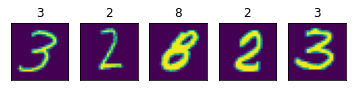

In [13]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [17]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [18]:
class MLPModel(nn.Module):
    def __init__(self, input_dim=mnist_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout=0.5):
        super(MLPModel, self).__init__()

        self.isCNNmodel = False

        self.dropout = nn.Dropout(dropout)

        #print("hidden_dim = ", hidden_dim)
        self.numberOfSparseLayers = numberOfSparseLayersMLP   #default: 1 (1 or 2)
        self.numberOfchannelsFirstDenseLayer = numberOfchannelsFirstDenseLayerMLP

        numberOfchannels = self.numberOfchannelsFirstDenseLayer 

        self.linear1 = nn.Linear(input_dim, numberOfchannels)  #first/dense linear layer 

        self.sparseLayerProcessing = SparseLayerProcessing(self.isCNNmodel, self.numberOfSparseLayers, self.dropout, self.numberOfchannelsFirstDenseLayer)

        numberOfchannels, _, _ = self.sparseLayerProcessing.generateSparseLayers(numberOfchannels)

        self.output = nn.Linear(numberOfchannels, output_dim)

    def forward(self, x, **kwargs):

        #first/dense linear layer
        x = self.linear1(x)
        x = self.sparseLayerProcessing.activationFunction(x)

        x = self.sparseLayerProcessing.executeSparseLayers(x)

        if(onlyTrainFinalLayer):
            x = x.detach()

        x = F.softmax(self.output(x), dim=-1)

        return x



skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [19]:
from skorch import NeuralNetClassifier

In [20]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MLPModel,
    max_epochs=numberOfEpochsMLP,
    lr=0.1,
    device=device,
    batch_size=batchSizeMLP,
)

In [ ]:
net.fit(X_train, y_train)

## Prediction

In [22]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = net.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [ ]:
error_mask = y_pred != y_test

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
XCnn.shape

In [ ]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
XCnn_train.shape, y_train.shape

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNNModel, self).__init__()

        self.isCNNmodel = True

        height = 28 #MNIST defined
        width = 28  #MNIST defined
        self.kernelSize = 3
        self.padding = 0
        self.stride = 1
        self.maxPoolSize = 2 #assume max pool at each layer

        self.conv2_drop = nn.Dropout2d(p=dropout)

        self.numberOfSparseLayers = numberOfSparseLayersCNN #default: 1 (1 or 2)
        self.numberOfchannelsFirstDenseLayer = numberOfchannelsFirstDenseLayerCNN

        numberOfchannels = self.numberOfchannelsFirstDenseLayer  
        self.conv1 = nn.Conv2d(1, numberOfchannels, kernel_size=self.kernelSize, padding=self.padding, stride=self.stride)  #first/dense linear layer

        self.sparseLayerProcessing = SparseLayerProcessing(self.isCNNmodel, self.numberOfSparseLayers, self.conv2_drop, self.numberOfchannelsFirstDenseLayer, kernelSize=self.kernelSize, padding=self.padding, stride=self.stride, maxPoolSize=self.maxPoolSize)
        
        height, width = self.sparseLayerProcessing.getImageDimensionsAfterConv(height, width, self.kernelSize, self.padding, self.stride, self.maxPoolSize)
        numberOfchannels, width, height = self.sparseLayerProcessing.generateSparseLayers(numberOfchannels, height, width)

        firstLinearInputSize = numberOfchannels*width*height

        self.fc1 = nn.Linear(firstLinearInputSize, 100)
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):

        x = self.conv1(x)
        x = self.sparseLayerProcessing.activationFunction(x, useDropOut=False)

        x = self.sparseLayerProcessing.executeSparseLayers(x)

        if(onlyTrainFinalLayer):
            x = x.detach()

        # flatten over channel, height and width
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        return x
     

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    CNNModel,
    max_epochs=numberOfEpochsCNN,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=batchSizeCNN,
)

In [ ]:
cnn.fit(XCnn_train, y_train)

In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [ ]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

Over 70% of the previously misclassified images are now correctly identified.

In [ ]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])